In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3, DenseNet201, Xception, EfficientNetB4, NASNetLarge
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, VGG19, NASNetMobile,VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# Image dimensions
img_width, img_height = 224, 224  # Adjust based on your dataset

train_data_dir = 'train/'  # Path to the parent folder containing 'original' and 'fake' folders
test_data_dir = 'test/'  # Path to the parent folder containing 'original' and 'fake' folders

# augmented_data_dir = 'augmented_train/'
batch_size = 32

2024-02-19 16:00:09.851312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 16:00:11.220389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Use a separate validation data generator without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Generate data batches
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow test images from the test directory without augmentation
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  
)


Found 11532 images belonging to 2 classes.
Found 2881 images belonging to 2 classes.
Found 3603 images belonging to 2 classes.


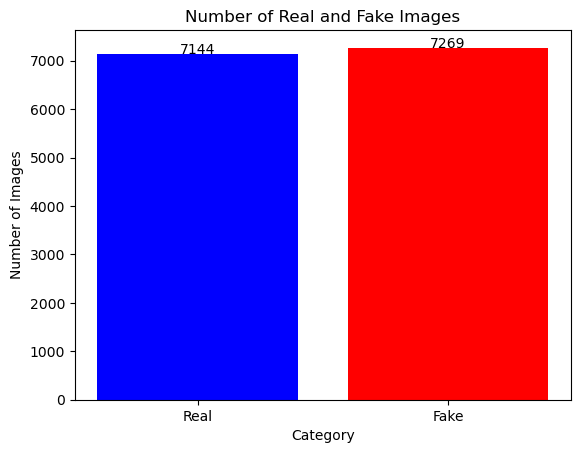

In [4]:
import os
import matplotlib.pyplot as plt

# Subdirectories representing real and fake images
real_dir = os.path.join(train_data_dir, 'real')
fake_dir = os.path.join(train_data_dir, 'fake')

# Count the number of images in each subdirectory
real_count = len(os.listdir(real_dir))
fake_count = len(os.listdir(fake_dir))

# Plotting the bar graph
labels = ['Real', 'Fake']
counts = [real_count, fake_count]

plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Real and Fake Images')
plt.text(0, real_count, str(real_count), ha='center')
plt.text(1, fake_count, str(fake_count), ha='center')
plt.show()


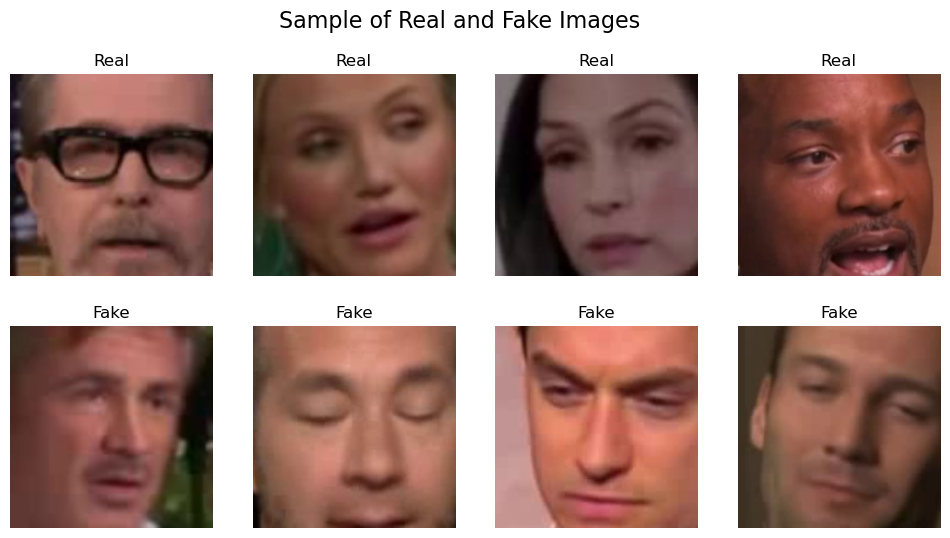

In [5]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory containing the train data
train_dir = 'train'

# Subdirectories representing real and fake images
real_dir = os.path.join(train_dir, 'real')
fake_dir = os.path.join(train_dir, 'fake')

# Get a list of file names in each subdirectory
real_images = os.listdir(real_dir)
fake_images = os.listdir(fake_dir)

# Randomly select 4 images from each subdirectory
random_real_images = random.sample(real_images, 4)
random_fake_images = random.sample(fake_images, 4)

# Plotting the sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, img_name in enumerate(random_real_images):
    img_path = os.path.join(real_dir, img_name)
    img = mpimg.imread(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('Real')

for i, img_name in enumerate(random_fake_images):
    img_path = os.path.join(fake_dir, img_name)
    img = mpimg.imread(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Fake')

plt.suptitle('Sample of Real and Fake Images', fontsize=16)
plt.show()


In [6]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

2024-02-19 16:00:15.527094: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Unfreeze the last 10% of the convolutional layers
num_layers = len(base_model.layers)
num_unfreeze = int(0.1 * num_layers)

for layer in base_model.layers[:num_layers - num_unfreeze]:
    layer.trainable = False

for layesr in base_model.layers[num_layers - num_unfreeze:]:
    layer.trainable = True

# Use a lower learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [8]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [9]:

# Import the metrics modules
from tensorflow.keras.metrics import AUC, Precision, Recall

# # Define a custom F1-score metric
# def F1_score(y_true, y_pred):
#   precision = Precision()(y_true, y_pred)
#   recall = Recall()(y_true, y_pred)
#   return 2 * (precision * recall) / (precision + recall + 1e-6)
# Compile the model with the metrics
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', AUC()],  # Precision(), Recall(), F1_score],
              run_eagerly=True,)

In [10]:
# Create a ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 patience=3,
                                                 min_lr=1e-6,
                                                 mode='min',
                                                 verbose=1)


In [11]:
# Create an EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              min_delta=0.01,
                                              patience=5,
                                              mode='max',
                                              verbose=1)


In [ ]:
# Train the model with callbacks and metrics
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[reduce_lr, early_stop]  # Pass the callbacks to the fit method
)


Epoch 1/10
207/360 [================>.............] - ETA: 19:27 - loss: 0.4184 - accuracy: 0.8069 - auc: 0.8899

In [ ]:
model.summary()

In [ ]:
model.save("DenseNet201_retry_model_implementation.h5")


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()